In [34]:
from astroquery.mast import Observations
from astropy.io import fits
from astropy.table import Table
import math

In [23]:
tic = 270577175
obsTable = Observations.query_criteria(provenance_name='TESS-SPOC',target_name=tic)
data = Observations.get_product_list(obsTable)

In [24]:
#download_lc = Observations.download_products(data)

In [25]:
cd hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp/


[Errno 2] No such file or directory: 'hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp/'
/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt/mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp


In [26]:
ls

hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits
hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_tp.fits


In [56]:
hdulist = fits.open('hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')
hdulist[1].data

FITS_rec([(1468.28332026, 0.00154374, 11559, 5440095. , 64.05369, 11814.139, 6.1606474,       nan,       nan, 8, nan, nan, nan, nan, 1661.22948378, 1.20871273e-05, 619.01059233, 5.3862706e-05,         nan,         nan),
          (1468.3041536 , 0.00154376, 11560, 5441052.5, 64.05927, 11819.849, 6.1587396, 5507612. , 64.86285 , 0, nan, nan, nan, nan, 1661.22873677, 1.20848999e-05, 619.01157383, 5.3873198e-05,  0.01709123,  0.04153716),
          (1468.32498695, 0.00154379, 11561, 5440696.5, 64.05729, 11821.125, 6.1617174, 5507246.5, 64.86083 , 0, nan, nan, nan, nan, 1661.22803465, 1.20856666e-05, 619.01201823, 5.3865642e-05,  0.01612137,  0.04193074),
          ...,
          (1489.99151787, 0.00141688, 12601, 5443009. , 64.06723, 11567.07 , 6.126722 , 5509699.5, 64.870895, 0, nan, nan, nan, nan, 1661.21266742, 1.21172870e-05, 618.93175386, 5.3750755e-05,  0.0006166 , -0.07778622),
          (1490.01235089, 0.00141656, 12602, 5442564. , 64.0643 , 11550.364, 6.121054 , 5508939. , 64.867

In [57]:
def import_lightcurve(file_path, drop_bad_points=False,
                      ok_flags=[5]):
    """Returns (N by 2) table, columns are (time, flux).

    Flags deemed to be OK are:
    5 - reaction wheel zero crossing, matters for short cadence
    """

    try:
        hdulist = fits.open(file_path)
    except FileNotFoundError:
        print("Import failed: file not found")
        return

    scidata = hdulist[1].data
    table = Table(scidata)['TIME','PDCSAP_FLUX','QUALITY']

    if drop_bad_points:
        bad_points = []
        q_ind = get_quality_indices(table['QUALITY'])
        for j,q in enumerate(q_ind):
            if j+1 not in ok_flags:
                bad_points += q.tolist()

        # bad_points = [i for i in range(len(table)) if table[i][2]>0]
        table.remove_rows(bad_points)

    # Delete rows containing NaN values.
    nan_rows = [ i for i in range(len(table)) if
            math.isnan(table[i][1]) or math.isnan(table[i][0]) ]

    table.remove_rows(nan_rows)

    # Smooth data by deleting overly 'spikey' points.
    spikes = [ i for i in range(1,len(table)-1) if \
            abs(table[i][1] - 0.5*(table[i-1][1]+table[i+1][1])) \
            > 3*abs(table[i+1][1] - table[i-1][1])]

    for i in spikes:
        table[i][1] = 0.5*(table[i-1][1] + table[i+1][1])

    return table


In [58]:
table = import_lightcurve('hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits')
len(table['TIME'])

971

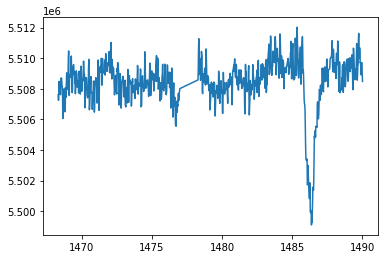

In [61]:
import matplotlib.pyplot as plt
plt.plot(table['TIME'],table['PDCSAP_FLUX'])